In [6]:
%cd /home/x_amime/x_amime/projects/an_explanation_model/

/proj/azizpour-group/users/x_amime/projects/an_explanation_model


/home/x_amime/x_amime/envs/.conda/envs/xlab/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [7]:
from source.labels import IMAGENET_LABELS
import pandas as pd
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os

from commands.experiment_7_1 import (
    dataset_dir,
    input_shape,
)

save_metadata_dir = "outputs/metadata/experiment_7_*_*/"


imshow_args = {"cmap": "jet"}

# run once
# merged_experiment_metadata = merge_experiment_metadata(save_metadata_dir=save_metadata_dir, glob_path="experiment_7_*/sl_merged_*.csv")

In [8]:
paths = os.path.join(save_metadata_dir, "merged_??q_*.csv")
paths = glob(paths)
print(paths)
merged_data = []
for path in paths:
    slq_csv = pd.read_csv(path)
    merged_data.append(slq_csv)
merged_data = pd.concat(merged_data, axis=0)


def minmax_normalize(x: np.ndarray, q=0.99):
    x[x > np.quantile(x, q=q)] = np.quantile(x, q=q)
    return (x - x.min()) / (x.max() - x.min())

['outputs/metadata/experiment_7_2_additive_combination_0/merged_slq_metadata.csv', 'outputs/metadata/experiment_7_2_additive_combination_0/merged_igq_metadata.csv']


In [9]:
# set type of merged_data.alpha_mask_value to str
merged_data.alpha_mask_value = merged_data.alpha_mask_value.astype(str)

print(merged_data.q.unique())
print(merged_data.alpha_mask_value.unique())

[10. 50. 90. 30. 70.]
['sl_b_0_1.0_meanx2' 'ig_sg_b_0_1.0_meanx' 'ig_sg_b_0_1.0_meanx2']


In [10]:
merged_data = merged_data[merged_data.stream_name == "vanilla_grad_mask"]
merged_data.shape

(15000, 12)

In [11]:
temp = merged_data[merged_data.ig_elementwise == False]
temp.q.value_counts()

q
10.0    3000
50.0    3000
90.0    3000
30.0    3000
70.0    3000
Name: count, dtype: int64

In [12]:
merged_data.alpha_mask_value = merged_data.alpha_mask_value + "_" +\
    merged_data.baseline_mask_type + "_" +\
    merged_data.stream_statistic
merged_data.alpha_mask_value.value_counts()

alpha_mask_value
sl_b_0_1.0_meanx2_gaussian-0.3_meanx2       5000
ig_sg_b_0_1.0_meanx_gaussian-0.3_meanx      5000
ig_sg_b_0_1.0_meanx2_gaussian-0.3_meanx2    5000
Name: count, dtype: int64

In [13]:
merged_data_acc = merged_data.groupby(
    ["alpha_mask_value", "q"])["preds"].mean()
merged_data_acc.name = "Accuracy"
merged_data_acc = merged_data_acc.reset_index()

In [14]:
selection = merged_data_acc.groupby("alpha_mask_value")[
    "Accuracy"].mean().sort_values()
print(selection)
values = selection.values
selection = selection.index
len(selection)

alpha_mask_value
ig_sg_b_0_1.0_meanx2_gaussian-0.3_meanx2    0.2216
sl_b_0_1.0_meanx2_gaussian-0.3_meanx2       0.2224
ig_sg_b_0_1.0_meanx_gaussian-0.3_meanx      0.2672
Name: Accuracy, dtype: float64


3

In [10]:
def plot_accuracy_vs_q(selection,
                       figsize=(7, 7),
                       title="untitled",
                       values=None,
                       linestyle_fn=lambda x: None,
                       marker_fn=lambda x: None,
                       color_fn=lambda x: None):
    plt.figure(figsize=figsize)
    # draw vertical lines at ticks
    for q in merged_data_acc.q.unique():
        plt.axvline(q, linestyle=":", color="black", alpha=0.3, linewidth=1)
    # draw horizontal lines at ticks
    plt.ylim(0, 0.7)
    ticks = plt.yticks()[0]
    for acc in ticks:
        plt.axhline(
            acc,
            linestyle=":",
            color="black",
            alpha=0.3,
            linewidth=1,
        )

    for i, alpha in enumerate(selection):
        merged_data_acc_alpha = merged_data_acc[
            merged_data_acc.alpha_mask_value == alpha
        ]
        plt.plot(
            merged_data_acc_alpha.q,
            merged_data_acc_alpha.Accuracy,
            label=alpha+" " +
            f"{values[i]:.3f}" if values is not None else alpha,
            linestyle=linestyle_fn(alpha),
            marker=marker_fn(alpha),
            color=color_fn(alpha),
        )

    # location top right
    plt.legend(loc="upper right")
    plt.xlabel("% of pixels masked")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.savefig(f"outputs/figures/{title}.pdf", bbox_inches="tight")

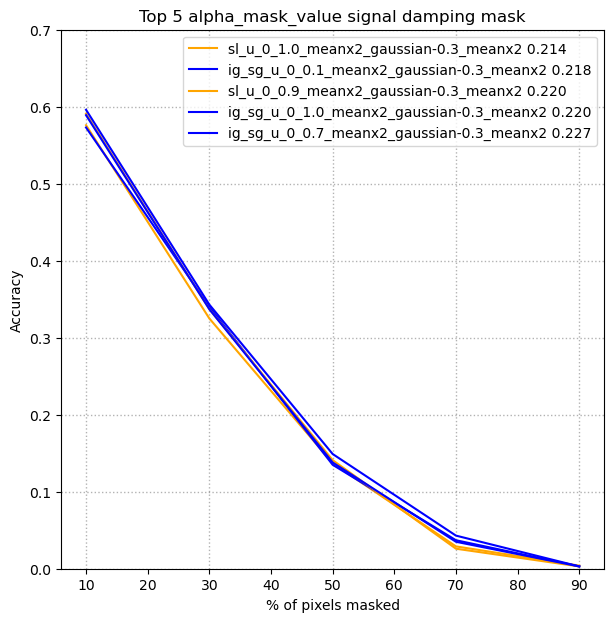

In [11]:
def linestyle_fn(alpha): return "-" if "meanx2" in alpha else "--"
def color_fn(alpha): return "blue" if "ig" in alpha else "orange"


plot_accuracy_vs_q(selection[:5],
                   title="Top 5 alpha_mask_value signal damping mask",
                   values=values[:5],
                   color_fn=color_fn,
                   linestyle_fn=linestyle_fn)

2024-02-06:21:48:12,804 WARNING  [legend.py:1323] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


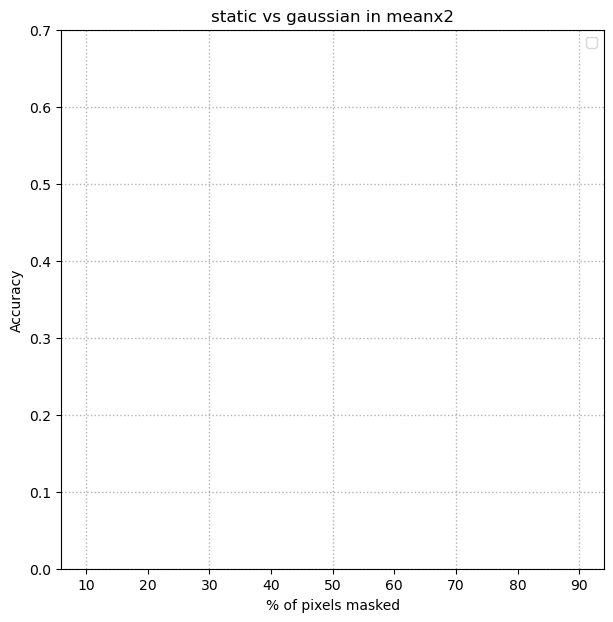

In [82]:
temp_ids = ["meanx2" in s and "ig" not in s and "sl" not in s for s in selection]
colors = plt.cm.jet
def color_fn(alpha): return colors(float(alpha.split("_")[0]))
def linestyle_fn(alpha): return "-" if "static" in alpha else "--"
def marker_fn(alpha): return "o" if "norm" in alpha else "x"


plot_accuracy_vs_q(selection[temp_ids],
                   title="static vs gaussian in meanx2",
                   values=values[temp_ids],
                   color_fn=color_fn,
                   linestyle_fn=linestyle_fn,
                   marker_fn=marker_fn)

2024-02-06:17:37:39,609 WARNING  [legend.py:1323] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


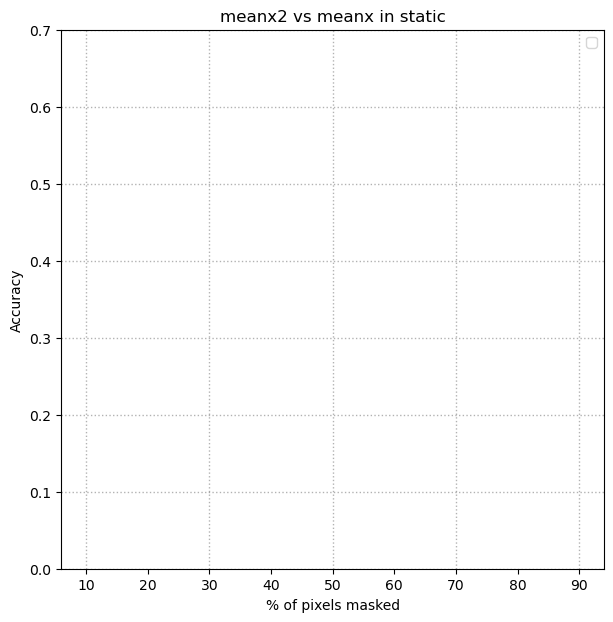

In [13]:
temp_ids = ["static" in s and not "ig" in s for s in selection]
def color_fn(alpha): return colors(float(alpha.split("_")[0]))
def linestyle_fn(alpha): return "-" if "meanx2" in alpha else "--"


plot_accuracy_vs_q(selection[temp_ids],
                   title="meanx2 vs meanx in static",
                   values=values[temp_ids],
                   color_fn=color_fn,
                   linestyle_fn=linestyle_fn)

2024-02-06:17:37:41,655 WARNING  [legend.py:1323] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


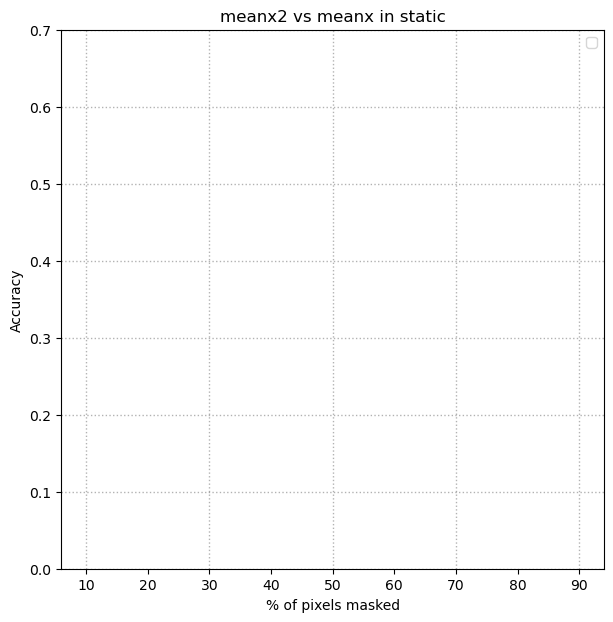

In [14]:
temp_ids = ["gaussian" in s and not "ig" in s and "meanx2" in s and "sl" not in s for i,s in enumerate(selection)]
def color_fn(alpha): return colors(float(alpha.split("_")[0]))
def linestyle_fn(alpha): return "-" if "meanx2" in alpha else ":"


plot_accuracy_vs_q(selection[temp_ids],
                   title="meanx2 vs meanx in static",
                   values=values[temp_ids],
                   color_fn=color_fn,
                   linestyle_fn=linestyle_fn)

Text(0.5, 1.0, 'meanx')

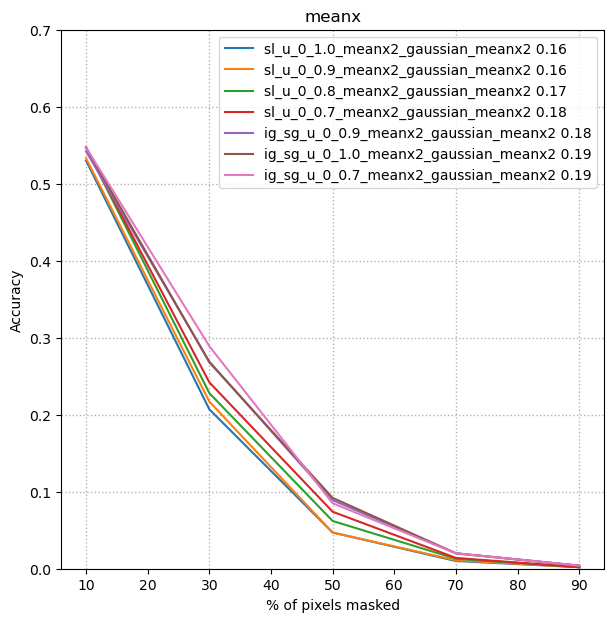

In [15]:
temp_ids = ["ig" in s or "sl" in s for s in selection]
linestyle_fn = lambda x: "-" if "meanx2" in x else "--"
plot_accuracy_vs_q(selection[temp_ids],
                   values=values[temp_ids], title="meanx2 vs meanx",
                   linestyle_fn=linestyle_fn,)
plt.title("meanx")

<Axes: xlabel='q', ylabel='alpha_mask_value'>

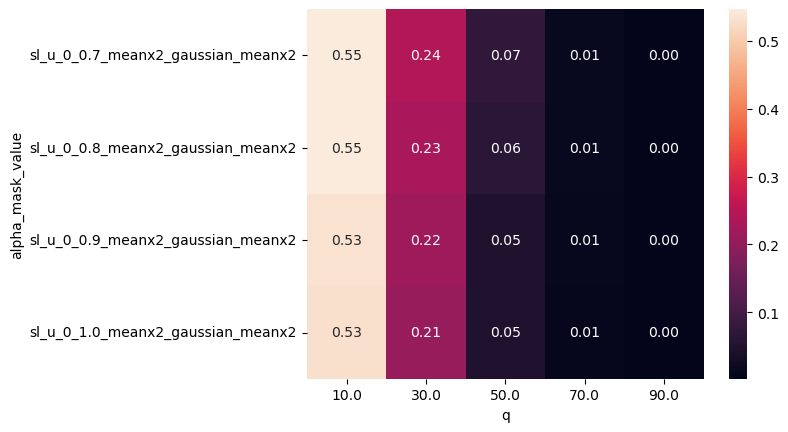

In [16]:
accs = merged_data[
    merged_data.alpha_mask_value.apply(
        lambda x: "sg" not in x and "meanx2" in x and "gaussian" in x
    )
]
accs = accs.pivot_table(
    index="alpha_mask_value", columns="q", values="preds", aggfunc="mean"
)
# accs = accs.apply(lambda x: 1-x / x.max(), axis=0)
accs = accs.astype(float)
sns.heatmap(
    accs,
    # cmap="viridis",
    annot=True,
    fmt=".2f",
)

outputs/metadata/experiment_7_2_additive_combination_0/merged_metadata.csv


/tmp/ipykernel_4097030/1192050590.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  temp = temp.loc["log_probs","data_path"]


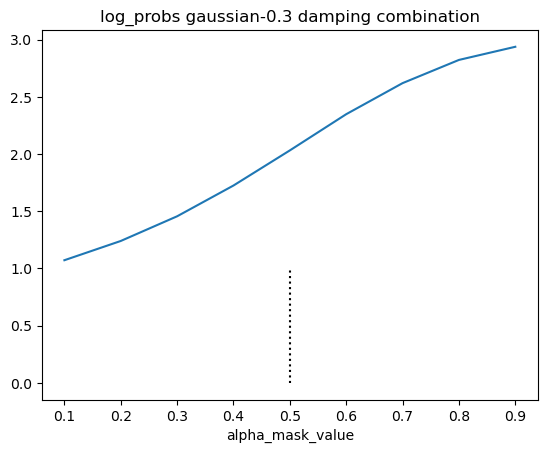

In [5]:
path = os.path.join(save_metadata_dir, "merged_metadata.csv")
path = glob(path)[0]
print(path)
merged_data = pd.read_csv(path)
temp = merged_data.set_index(
    [
        "stream_name",
        "alpha_mask_value",
    ]
)
temp = temp.loc["log_probs","data_path"]
temp = temp.apply(lambda x: np.load(x))
temp = temp.apply(lambda x: -(x*np.exp(x)).sum())
temp = temp.groupby("alpha_mask_value").mean()
temp.to_csv("outputs/processed/damping_combination.csv")
temp.plot()
plt.title("log_probs gaussian-0.3 damping combination")
plt.vlines(0.5, 0, 1, color="black", linestyle=":")
plt.savefig("outputs/figures/log_probs_gaussian-0.3_damping_combination.pdf")

In [ ]:
actual_qs = merged_data.groupby(["alpha_mask_value", "q"])["actual_q"].mean()
actual_qs = actual_qs.reset_index()
actual_qs[actual_qs.alpha_mask_value.apply(lambda x: "sg_" in x)]

In [10]:
# # copy files
# base_path = "outputs/metadata/experiment_7/"
# paths = "outputs/metadata/experiment_7_1_*/slq*"
# for path in glob(paths):
#     newpath = "_".join(path.split("/")[-2:])
#     newpath = os.path.join(base_path, newpath)
#     # copy file from path to newpath
#     os.system(f"cp {path} {newpath}")

(100, 29)
(100, 32)
